# Introduction

Neuroimaging analysis results are affected the propagation of numerical differences between versions of the GNU C library (glibc) [[1]](https://www.frontiersin.org/articles/10.3389/fninf.2015.00012/full). Furthermore, such differences are accurately simulated by introducing random perturbations in the least-significant bits of elementary mathematical function results [[2]](http://example.com). In some cases, such differences are not negligible with respect to anatomical variability, image acquisition noise, and differences among data processing toolboxes [[3]](https://www.biorxiv.org/content/10.1101/2020.10.15.341495v1). The observed numerical variability is at the same time concerning, as it undermines the stability of neuroimaging results, and interesting, as it can be leveraged as a data augmentation technique [[4]](https://www.biorxiv.org/content/10.1101/2020.12.16.423084v1).

Multiple mathematical libraries have been developed and their numerical accuracy differ. The work in [[5]](https://members.loria.fr/PZimmermann/papers/accuracy.pdf) establishes upper bounds on the accuracy of single-precision mathematical functions and lower bounds on the accuracy of double-precision functions. 

In this work we compare neuroimaging results obtained with different mathematical libraries, addressing the following questions:

1. What is the variability resulting from the use of different mathematical libraries in neuroimaging?
2. What is the numerical accuracy of neuroimaging results obtained with different libraries?
3. What is the origin of numerical errors?
4. What is the impact of the observed numerical errors on neuroimaging experiments?

# Methods

## Application

Neuroimaging pipelines are diverse, covering different image modalities (mainly structural, functional, and diffusion MRI) and analysis types (image pre-processing, processing and statistics). We selected the [HCP minimal pre-processing pipelines](https://github.com/Washington-University/HCPpipelines) as they cover all these modalities, are based on the widely used [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki) library, and are developed in a flagship neuroscience data sharing project. For this analysis we focus on `PreFreesurfer`, the first tool applied for structural MRI pre-processing in HCP pipelines. We verified that multiple runs of the pipeline on the same dataset in the same execution conditions produced identical results.

## Data

We randomly selected 20 subjects from the HCP data release S500 available in the [ConnectomeDB](https://db.humanconnectome.org/app/template/Login.vm;jsessionid=FF41F747B902750ADDB40A2A165BEB73). The `PreFreesurfer` pipeline warps T1-weighted and T2-weighted images to the common MNI space, finding and applying various linear and non-linear geometric transformations. Each subject has one or two T1 or T2 images.

## Mathematical libraries

We tested [Musl](https://www.musl-libc.org) version 1.1.24-1, used in [Alpine Linux](https://alpinelinux.org), [OpenLibm](https://github.com/JuliaMath/openlibm) version 0.7.5, used in the Julia programming language, [Intel oneAPI Base Toolkit](https://software.intel.com/content/www/us/en/develop/tools/oneapi/base-toolkit/download.html#gs.zgfmhs), and glibc version 2.31, available in Ubuntu 20. To execute the application without having to recompile it with these different libraries, which might have resulted in other side effects, we dynamically intercepted mathematical function calls through a [wrapper library](https://github.com/glatard/manymaths/blob/main/wrap/wrap.c) preloaded using LD_PRELOAD and redirected them to the target library. We installed the mathematical and wrapper libraries in a [Docker image](https://github.com/glatard/manymaths/blob/main/Dockerfile) called "manymaths".

We evaluated numerical accuracy by comparison with [GNU MPFR](https://www.mpfr.org), a C library for multiple-precision floating-point computations with correct rounding. We instrumented the application to use GNU MPFR using the same LD_PRELOAD trick, using a slightly different but similar [wrapper library](https://github.com/glatard/manymaths/blob/main/wrap/wrap-mpfr.c).

## Execution platform

We processed the 20 HCP subjects with each of the 5 libraries using the "slashbin" cluster at Concordia University. Each compute node had 2 × 16-core Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz, 250 GiB of RAM, 6 × SSDs of 450 GiB each with the XFS file system, 378 GiB of tmpfs, 126 GiB of devtmpfs file system, and CentOS. We executed the application using a Singularity container image converted from Docker using `singularity build`. Each subject was processed sequentially.

*Note to self:* results are different on my laptop, this needs further investigation. 

# Results


## Variability between libraries


In [11]:
# Parse results

import os

def get_file(subject, lib):
    data_dir = os.path.join(os.getenv('HOME'), 'data', 'manymaths', '20-subjects-cluster', 'results')
    subject_dir = os.path.join(data_dir, lib, subject)
    return os.path.join(subject_dir, 'MNINonLinear', 'T1w.nii.gz')

lib_versions = ['glibc-v2.31', 'musl-v1.1.24-1', 'openlibm-v0.7.5', 'intel-v2021.2.0', 'mpfr' ]
subjects = ['101309', '102008', '102311', '103414', '103515', '103818', '105014', '105115',
            '106319', '106521', '107321', '107422', '108121', '108323', '113922', '140420',
            '140824', '140925', '142424', '142828' ]
files = [ get_file(subject, lib_version) for lib_version in lib_versions
                                         for subject in subjects ]

In [12]:
# RMSE functions

import nibabel as nib
import numpy as np

def data(image_file):
    
    '''
    Return a numpy array containing voxel values in image_file
    '''
    
    # Load foreground mask
    mask_img = os.path.join(os.getenv('HOME'), 'data', 'manymaths', "MNI152_T1_0.7mm_fg_mask.nii.gz")
    mask_img = nib.load(mask_img)
    mask_img_dat = mask_img.get_fdata()
    mask_locs = mask_img_dat > 0
    
    return nib.load(image_file).get_fdata()[mask_locs].flatten()

def rmse(data1, data2):
    '''
    Returns the RMSE between numpy arrays
    '''
    return np.sqrt(np.mean((data1-data2)**2, dtype=np.float64), dtype=np.float64)

def rmse_file(file1, file2):
    '''
    Return the RMSE between images in file 1 and file 2
    '''
    return rmse(data(file1), data(file2))
    
    
def rmse_subjs_libs(subject1, lib1, subject2, lib2):
    '''
    Return the RMSE between the result produced by 'lib1' and 'lib2', for subject 'subject'.
    '''
    return rmse_file(get_file(subject1, lib1), get_file(subject2, lib2))

In [13]:
# Compute RMSEs

import pandas as pd
import pickle
import os

dump_file = 'rmses.pkl' 

if os.path.exists(dump_file):
    df = pickle.load(open(dump_file, 'rb'))  # load df from disk

pairs = [ (s, v) for s in subjects for v in lib_versions ]
dump_file = 'rmses.pkl'

if os.path.exists(dump_file):
    df = pickle.load(open(dump_file, 'rb'))  # load df from disk
else:
    df = pd.DataFrame(index=pairs,columns=pairs)

for p in pairs:
    for q in pairs:
        if p == q:
            df[p][q] = 0
            continue
        if np.isnan(df[p][q]):
            print(f'Computing RMSE:  {q}')
            r = rmse_subjs_libs(p[0], p[1], q[0], q[1])
            df[p][q] = r
            df[q][p] =r
    pickle.dump(df, open(dump_file, 'wb'))  # dump df to disk

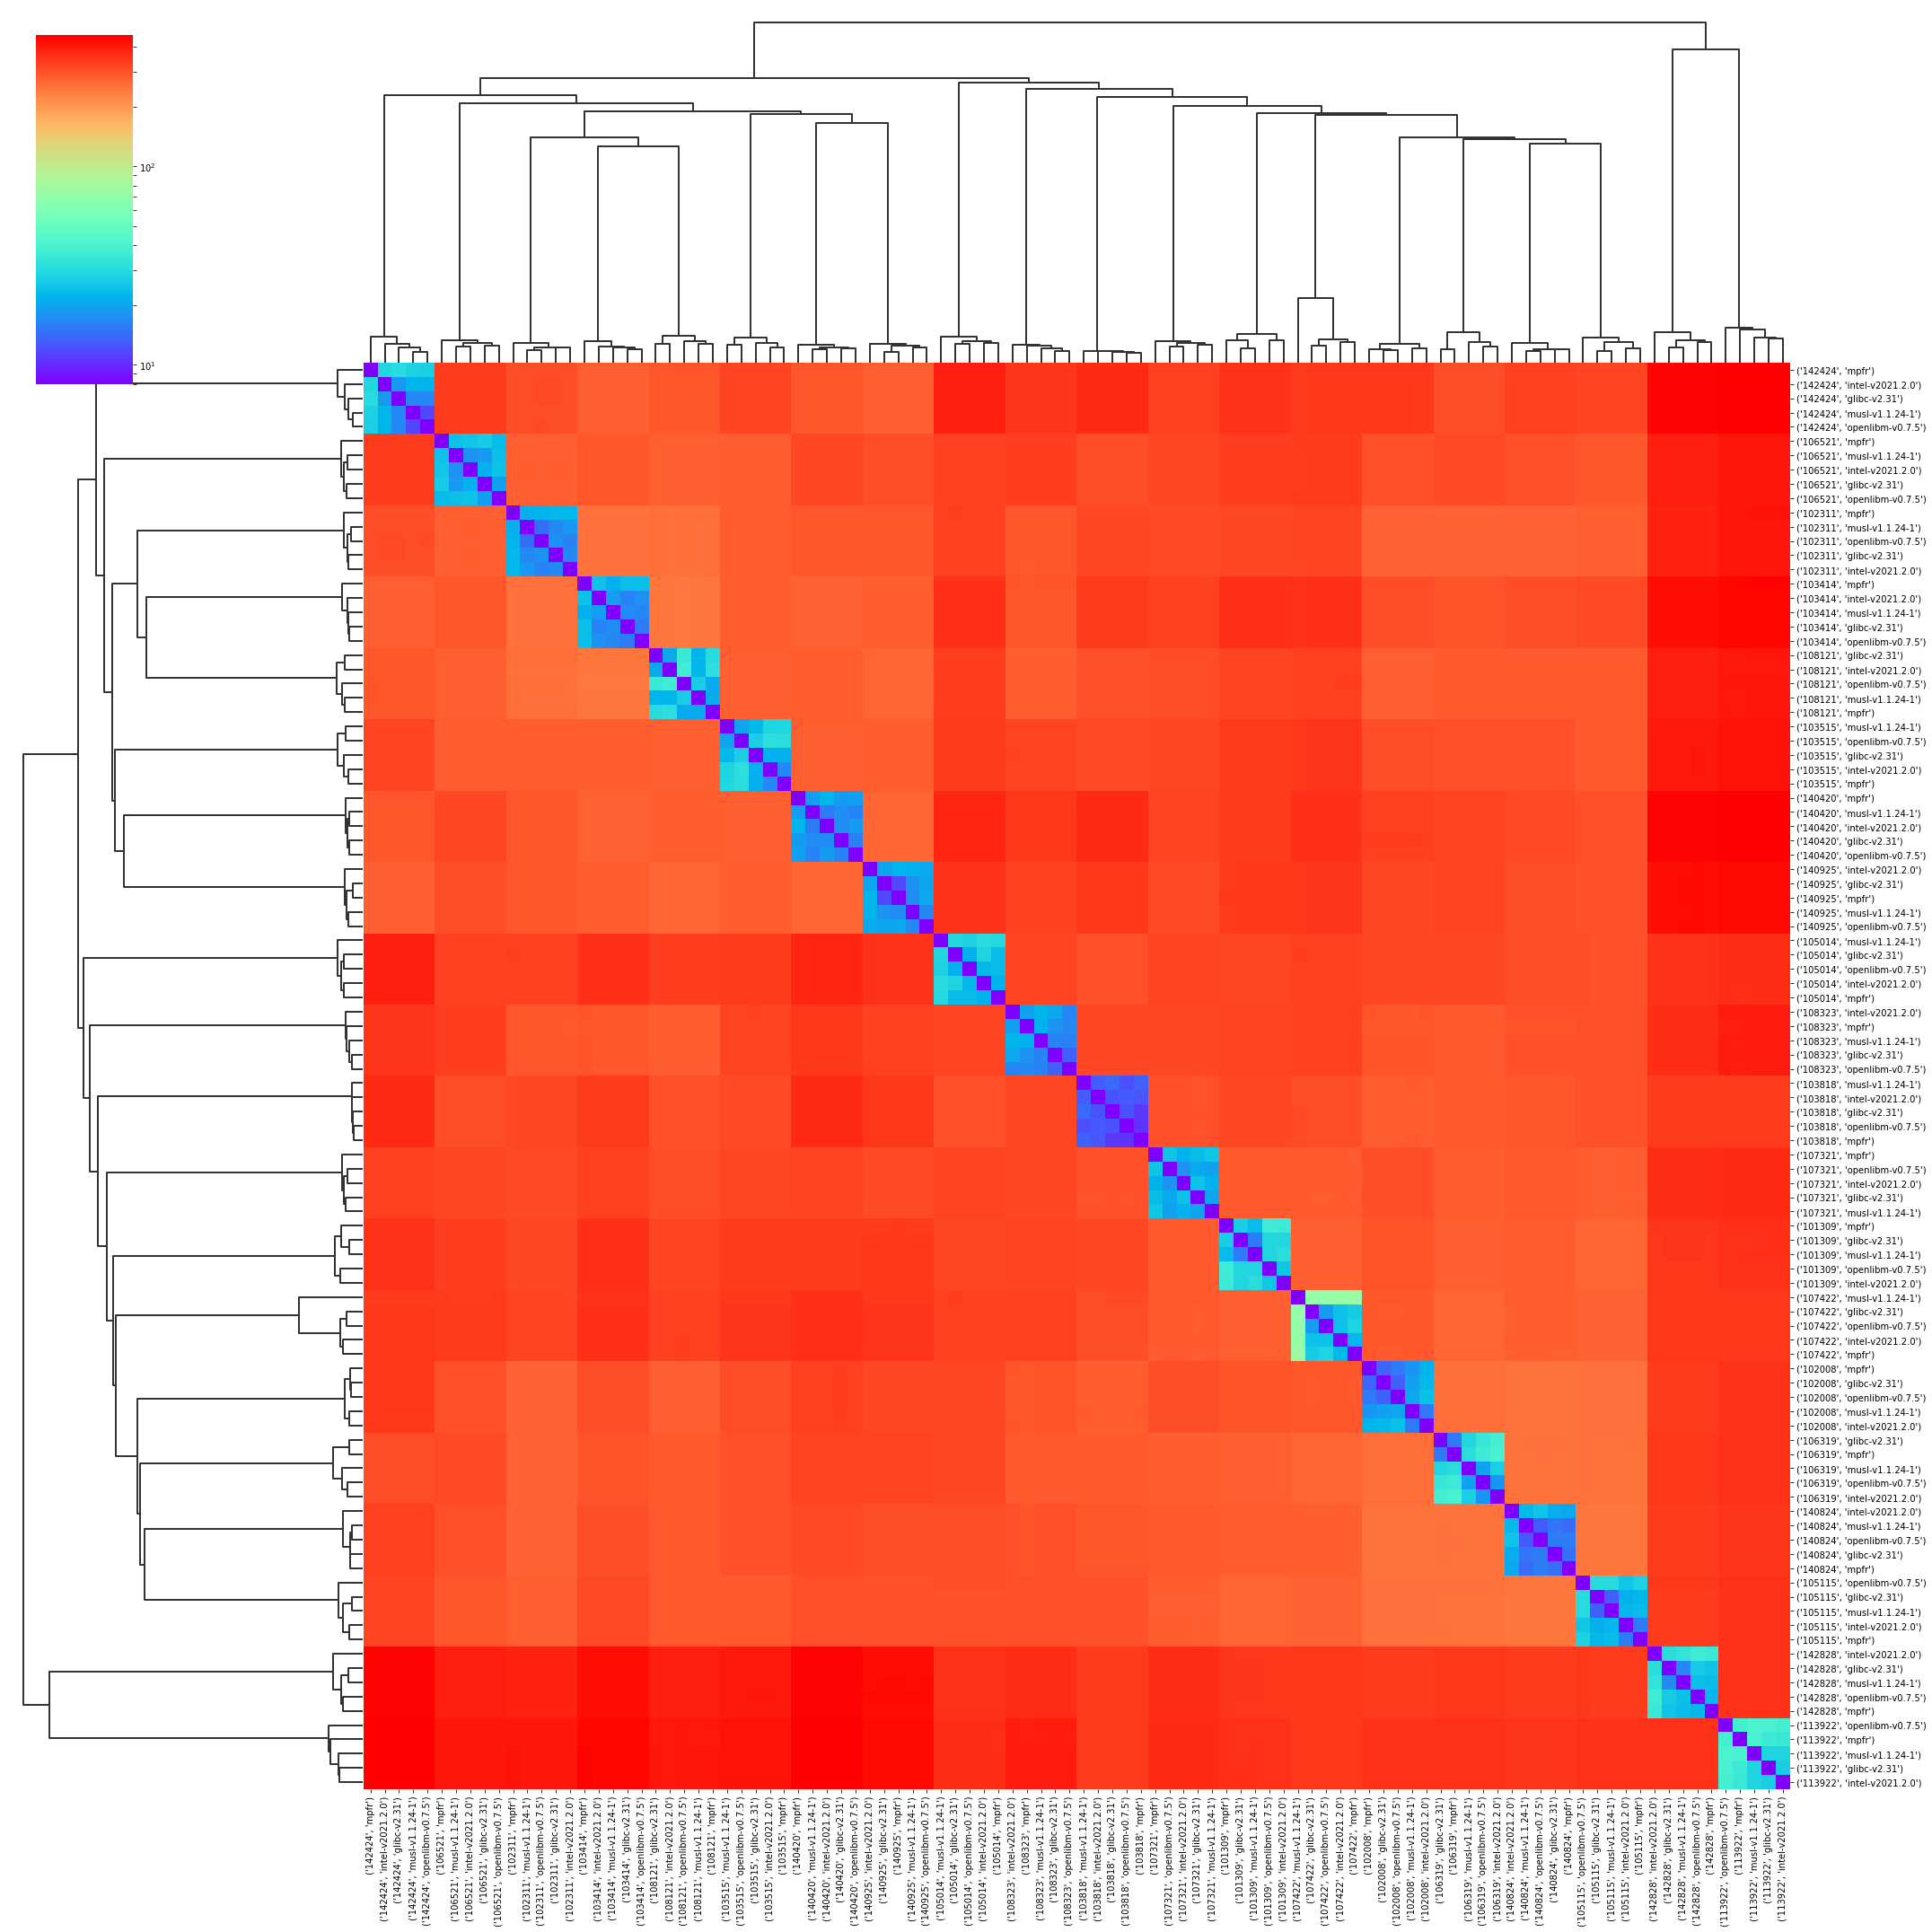

In [14]:
# Plot heatmap

from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import seaborn as sns
import matplotlib.colors as colors

df = df.fillna(0)  # FIXME

# see https://stackoverflow.com/questions/57308725/pass-distance-matrix-to-seaborn-clustermap

# define distance array as in linked answer
distArray = ssd.squareform(df) 

# define linkage object
distLinkage = hierarchy.linkage(distArray, 'average')

# make clustermap
absmax=75
c = sns.clustermap(df, vmin=0, row_linkage=distLinkage, col_linkage=distLinkage,
               figsize=(30,30), cmap='rainbow', norm=colors.SymLogNorm( vmin=8,
                                                                        linthresh=0.01, linscale=0.01,
                                                                        base=10))
lw = 2
for a in c.ax_row_dendrogram.collections:
    a.set_linewidth(2)

for a in c.ax_col_dendrogram.collections:
    a.set_linewidth(2)

(open image in new tab for a zoomable figure)

The figure above shows the Root Mean Squared Error (RMSE) between all the (subject, library) pairs. The between-subject differences are an order of magnitude larger than the between-library differences, which is reasonnable and consistent with previous observations.

The figure belows compares the results obtained for the 5 libraries, for the subject with the highest RMSE between them (subject 107422). The differences are visually important and could substantially impact downstream analyses.

<img src="out.gif"/>

## Numerical accuracy

We measure numerical accuracy by comparison with results obtained with the MPFR library.

In [5]:
import os

distances = {}

for ref_version in lib_versions:
    distances_to_ref = pd.DataFrame(index=subjects, columns=[v for v in lib_versions if v !=ref_version])
    for s in subjects:
        for v in lib_versions:
            if v == ref_version:
                continue
            if df[(s,v)][(s, ref_version)] != 0:
                distances_to_ref[v][s] = df[(s,v)][(s, ref_version)]
    distances[ref_version] = distances_to_ref
#     print(f'Distances to {ref_version}:')
#     print(distances_to_ref)

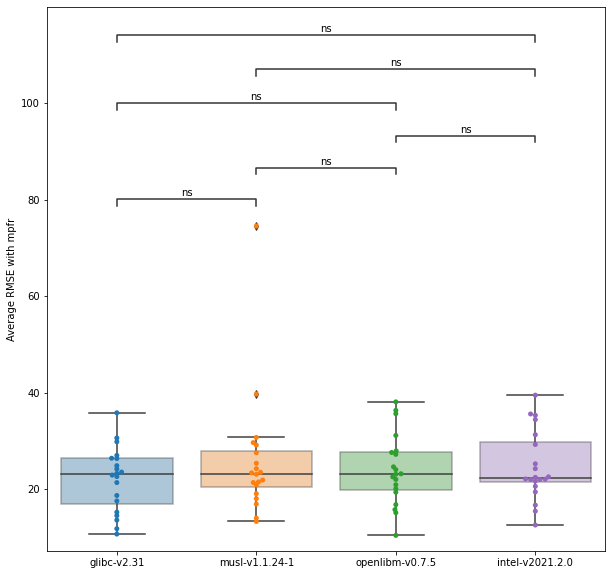

In [16]:
from matplotlib import pyplot as plt
from statannot import add_stat_annotation

fig, axs = plt.subplots(1, 1, figsize=(10,10))

colors = {
    'glibc-v2.31': 'tab:blue',
    'musl-v1.1.24-1': 'tab:orange',
    'openlibm-v0.7.5': 'tab:green',
    'intel-v2021.2.0': 'tab:purple',
    'mpfr': 'tab:red'
}
0
axs.set_ylabel(f"Average RMSE with {ref_version}")
sns.swarmplot(data=distances[ref_version], ax=axs, palette=colors)
c = sns.boxplot(data=distances[ref_version], boxprops=dict(alpha=.4), ax=axs, palette=colors)
test_results = add_stat_annotation(axs, data=distances[ref_version],
                                   box_pairs=[ (x, y) for x in lib_versions if x != ref_version 
          for y in lib_versions if y != ref_version if x != y if lib_versions.index(y) > lib_versions.index(x) ],
                                   test='t-test_ind', text_format='star',
                                   loc='inside', verbose=0)

All libraries produce results that are significantly different from the results produced with MPFR. However, no significant difference in numerical accuracy was found between any pair of libraries. 

## Origin of numerical errors

We traced mathematical function calls (DEBUG=1 option in the wrapper Makefile) during the processing of 1 subject with glibc and MPFR.

In [25]:
import bz2
import os

data_dir = os.path.join(os.getenv('HOME'), 'data', 'manymaths', 'rep-03')

def compare_traces(lib_versions, max_lines=100000000):
   
    assert(len(lib_versions) == 2)
    log_file = 'log_aa.bz2'  # won't read beyond the first log file for now

    file_names = [ os.path.join(data_dir, 'run-'+lib_version+'_log', log_file)
                   for lib_version in lib_versions ]
    bz_files = [ bz2.BZ2File(file_name) for file_name in file_names ]

    diffs = []  # will add a tuple here for each diff line

    def is_trace_line(line):
        return 'WRAP' in line

    call_id = 0
    next_line1 = None  # to handle "WRAP-DOUBLED lines"

    for i in range(max_lines):
        if i % 1000000 == 0:
            print(f'Tested {i} calls, found {len(diffs)} differences')
        if not next_line1 is None:
            line1 = next_line1
        else:
            line1 = bz_files[0].readline().decode('utf-8').strip()
        next_line1 = bz_files[0].readline().decode('utf-8').strip()
        if 'WRAP-DOUBLED' in next_line1:
            line1 = next_line1
            next_line1 = None
        line2 = bz_files[1].readline().decode('utf-8').strip()
    
        assert(is_trace_line(line1) == is_trace_line(line2))  # don't compare trace lines with non-trace lines
    
        if not is_trace_line(line1):  # don't bother with non trace lines
            continue
        
        call_id += 1
    
        if line1 == line2:
            continue

        # Found different trace lines: parse them
        splits1 = line1.split(" ")
        splits2 = line2.split(" ")
        func1 = splits1[1]
        args1 = [ float.fromhex(x.strip()) for x in splits1[2:] if str(x) != '' ]
        func2 = splits2[1]
        args2 = [ float.fromhex(x.strip()) for x in splits2[2:] if str(x) != '' ]
  
        if func1 != func2:
            print(i, "FUNCTION MISMATCH", line1, line2)
            break # don't go past the first function mismatch
    
        if args1 == args2:  # happens when args1[i] = 0 and args2[i] = -0
            continue

        def max_abs_val(list_):
            m = 0
            for i in range(len(list_)):
                if abs(list_[i]) > abs(m):
                    m = list_[i]
            return m
    
        def rel_diff(x, y):
            if y != 0:
                return (x-y)/y
            if x == y:
                return 0
            return float('inf')
    
        rel_diffs = [ rel_diff(args1[i], args2[i]) for i in range(len(args1)) ]    
        m = max_abs_val(rel_diffs)
    
        if func1 == 'sincosf' and abs(m) > 10E-8 and args1[0] == args2[0]:
            print('SINCOSF large error:', line1, line2)
    
        assert(m != 0), "\n"+line1+"\n"+line2+"\n"+str(m)  # there must be differences at this point
        diffs += [(call_id, func1, m, line1.replace('[WRAP]', ''), line2.replace('[WRAP]', ''))]
    print(f'Found {len(diffs)} differences in {call_id} function calls')
    return diffs

In [20]:
diffs = compare_traces(['glibc-v2.31', 'mpfr'])

Tested 0 calls, found 0 differences
35892 FUNCTION MISMATCH [WRAP] atan2f 0x1.76fc5ap-3 0x1.f7582ap-1   0x1.791dp-3 [WRAP] sincosf  0x1.3d82bp-3 0x1.3c3d76p-3 0x1.f9dbf4p-1
Found 2833 differences in 35820 function calls


Let's plot the differences observed until the first function mismatch:

In [21]:
import plotly.graph_objects as go

fig = go.Figure()

func_names = set([x[1] for x in diffs])

for func_name in func_names:
    func_diffs = [x for x in diffs if x[1] == func_name]
    fig.add_trace(go.Scatter(
                    x=[x[0] for x in func_diffs],
                    y=[x[2] for x in func_diffs],
                    mode='markers',
                    name=func_name, text=[(x[3] + " VS " + x[4]) for x in func_diffs]))

fig.update_layout(
    xaxis_title="Call #",
    yaxis_title="Relative difference"
)
fig.show()


Each point in the graph represents a function call. The reported relative difference (glibc-mpfr)/mpfr is the one with the largest absolute value among function input(s) and output(s). Differences between glibc and MPFR start appearing very early in the execution, at call 294. Differences originate in `logf`, `sincosf` and `atan2f`

To investigate whether differences between results produced by glibc and MPFR could be corrected, we modified the `logf`, `sincosf`, and `atan2f` functions in the wrapper as shown [here](https://github.com/glatard/manymaths/blob/main/wrap/wrap-doubled.c). The resulting "glibc-doubled" library was then compared against MPFR:

In [22]:
diffs = compare_traces(['glibc-v2.31_doubled_noexpf', 'mpfr'], max_lines=30000000)

Tested 0 calls, found 0 differences
Tested 1000000 calls, found 0 differences
Tested 2000000 calls, found 0 differences
Tested 3000000 calls, found 0 differences
Tested 4000000 calls, found 0 differences
Tested 5000000 calls, found 0 differences
Tested 6000000 calls, found 0 differences
Tested 7000000 calls, found 0 differences
Tested 8000000 calls, found 0 differences
Tested 9000000 calls, found 0 differences
Tested 10000000 calls, found 0 differences
Tested 11000000 calls, found 0 differences
Tested 12000000 calls, found 0 differences
Tested 13000000 calls, found 0 differences
Tested 14000000 calls, found 0 differences
Tested 15000000 calls, found 0 differences
Tested 16000000 calls, found 0 differences
Tested 17000000 calls, found 0 differences
Tested 18000000 calls, found 0 differences
Tested 19000000 calls, found 0 differences
Tested 20000000 calls, found 0 differences
Tested 21000000 calls, found 0 differences
Tested 22000000 calls, found 0 differences
Tested 23000000 calls, foun

The remaining detected differences are all in the `expf` function:

In [23]:
set([x[1] for x in diffs])

{'expf'}

After updating the "glibc-doubled" wrapper to correct function `expf` as the other ones, no difference remains between results obtained with glibc and with MPFR:

In [29]:
import hashlib

files = [ os.path.join(data_dir, lib_version, '101309', 'MNINonLinear', 'T1w.nii.gz')
                    for lib_version in ['glibc-v2.31_doubled', 'mpfr'] ]
hashes = [ hashlib.md5(open(filename,'rb').read()).hexdigest() for filename in files]
hashes

['e891000774953150b4a5b141f0eb6141', 'e891000774953150b4a5b141f0eb6141']

Correcting `logf`, `sincosf`, `atan2f`, and `expf` in glibc removed the differences with MPFR for this subject.

The corrected glibc implementation also removes differences with MPFR for the other 19 subjects that were tested.

In [31]:
lib_versions = ['glibc-v2.31_doubled', 'mpfr' ]
subjects = ['101309', '102008', '102311', '103414', '103515', '103818', '105014', '105115',
            '106319', '106521', '107321', '107422', '108121', '108323', '113922', '140420',
            '140824', '140925', '142424', '142828' ]
files = [ get_file(subject, lib_version) for lib_version in lib_versions
                                         for subject in subjects ]
hashes = set([ hashlib.md5(open(filename,'rb').read()).hexdigest() for filename in files])
len(hashes) == len(subjects)

True

# Conclusion

* Using double precision rather than single precision everywhere might be a good way to stabilize neuroimaging pipelines
* The LD_PRELOAD wrapper would be a practical way to do that without updating all the pipelines

# Future work

## Next
* Explain the differences observed between MPFR and {musl, openlibm, intel} using trace comparisons


## Later
* Measure imaging quality of the pipeline for each library by visual QC
* Measure "biological" performance of the pipeline for each library using age regression
* Measure numerical precision of the pipeline for each library using MCA (maybe not)

# Misc code

In [ ]:
# reformat pickled file
import pandas as pd

used_versions = [x for x in lib_versions if x not in excluded_versions]
pairs = [ (s, v) for s in subjects for v in used_versions ]
df_new = pd.DataFrame(index=pairs,columns=pairs)
for p in pairs:
    for q in pairs:
        if 'intel-v2021.2.0' in p or 'intel-v2021.2.0' in q:
            continue
        df_new[p][q] = df[p][q]
df_new
pickle.dump(df_new, open(dump_file, 'wb'))  # dump df to disk

## Visualization

Are the differences localized spatially?

<ipython-input-37-a724d7cb2720>:30: RuntimeWarning:

invalid value encountered in true_divide

/home/glatard/code/imcomp/venv/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning:

Non-finite values detected. These values will be replaced with zeros.

/home/glatard/code/imcomp/venv/lib/python3.8/site-packages/nilearn/plotting/displays.py:101: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



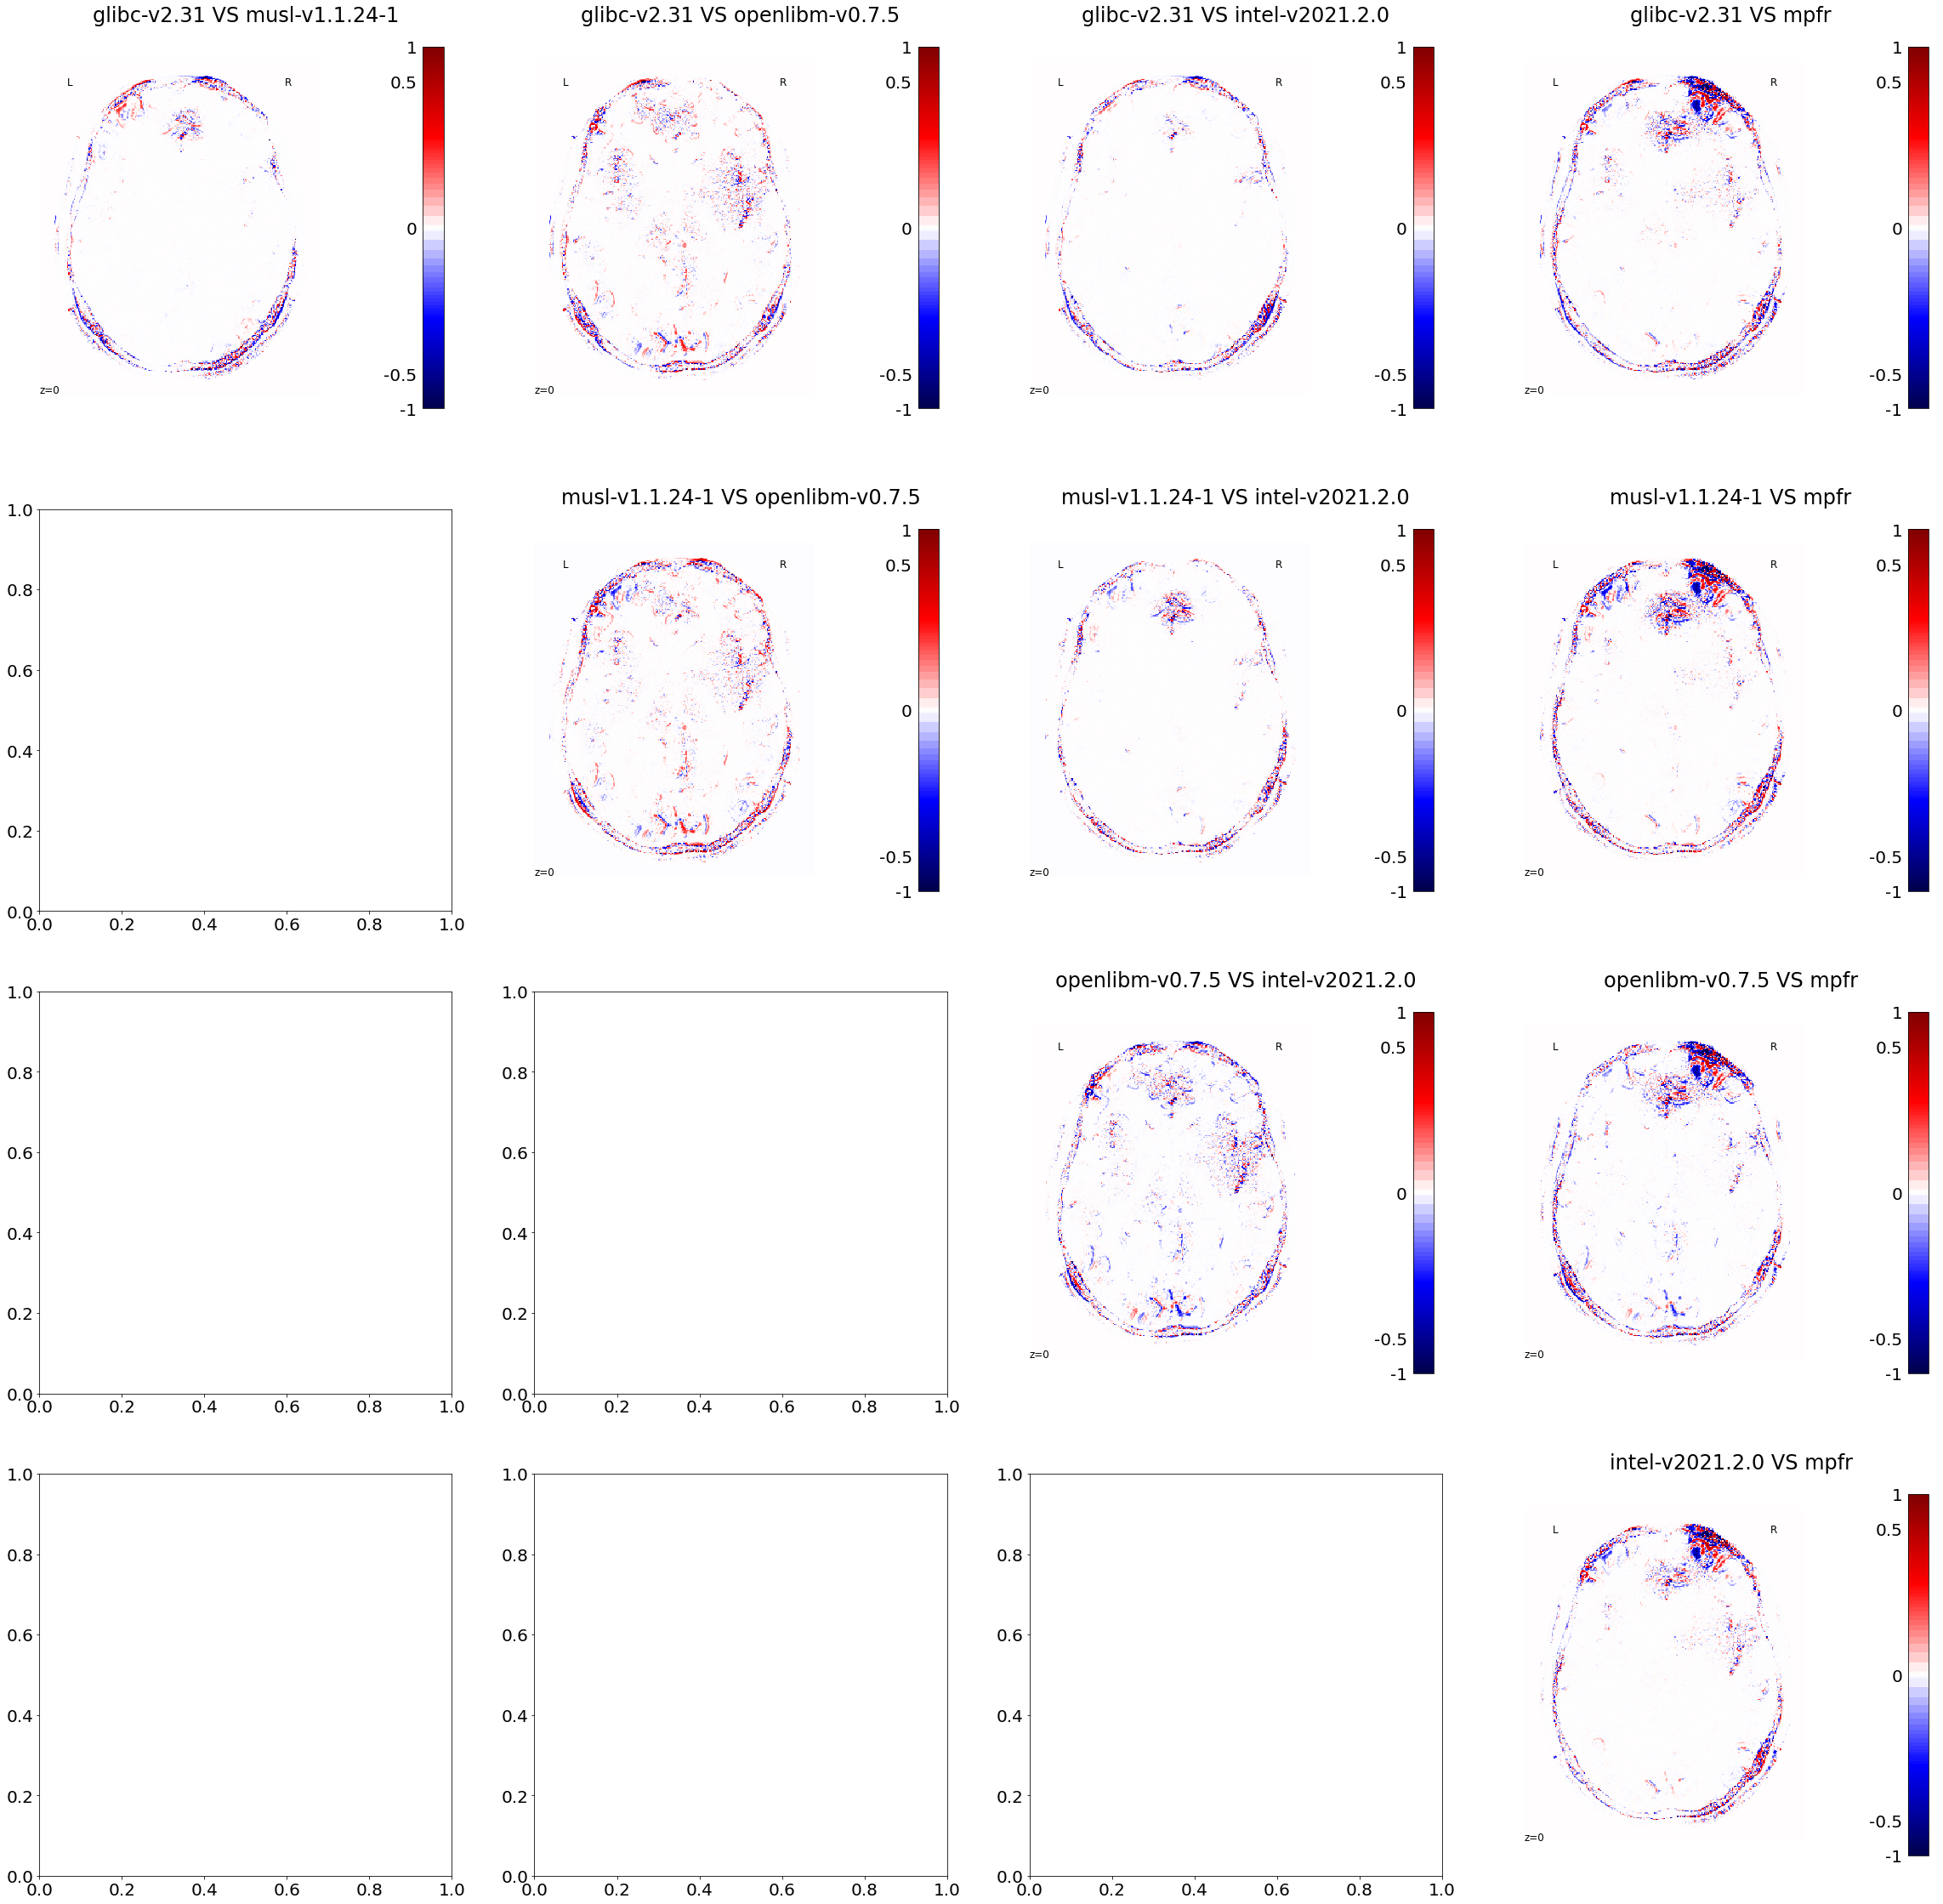

In [37]:
import matplotlib
import nilearn.plotting as nilp
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import matplotlib.colors as colors

matplotlib.rcParams.update({'font.size': 20})


lib_versions = ['glibc-v2.31', 'musl-v1.1.24-1', 'openlibm-v0.7.5', 'intel-v2021.2.0', 'mpfr' ]
subjects = ["101309"]

T1_data = [nib.load(os.path.join(data_dir, lib_version, subject, 'MNINonLinear', 'T1w.nii.gz'))
                    for lib_version in lib_versions for subject in subjects ]


# Load foreground mask
mask_img = os.path.join(os.getenv('HOME'), 'data', 'manymaths', "MNI152_T1_0.7mm_fg_mask.nii.gz")
mask_img = nib.load(mask_img)
mask_img_dat = mask_img.get_fdata()
    
fig, axs = plt.subplots(len(T1_data)-1, len(T1_data)-1, figsize=(40,40))

for i in range(len(T1_data)-1):
    for j in range(i+1, len(T1_data)):
        im1 = T1_data[i]
        data1 = im1.get_fdata()*mask_img_dat
        im2 = T1_data[j]
        data2 = im2.get_fdata()*mask_img_dat
        data = (data1-data2)/(data1)
        rel_diff = nib.Nifti1Image(data, im1.affine)
        axs[i, j-1].set_title(lib_versions[i]+" VS "+lib_versions[j])
        im = nilp.plot_img(rel_diff, cmap=cm.seismic, norm=colors.SymLogNorm(vmin=-1, vmax=1,
                                                                        linthresh=0.03, linscale=0.03,
                                                                        base=10),
                      cut_coords=(0,),
                      colorbar=True, draw_cross=False, display_mode='z', vmin=-1, vmax=1,
                      axes=axs[i, j-1])

plt.show()

**Notes**

MPFR results are very different from the other ones indeed.


A spatial dependency of numerical differences is observed. For instance, openlibm differs from the other libraries in the occipital lobe, and intel is singular in the frontal lobe. 

While it would be surprising that the spatial localization of such differences be consisent across subjects, it suggests that numerical libraries might be converging to different local minima during non linear registration.

Execution with MPFR took about 4.5 times longer than with the other libraries (354 min vs 80 min).

In [ ]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>
